Dataset and problem statement: "https://archive.ics.uci.edu/ml/datasets/Statlog+%28Shuttle%29" <br>
<br>
$ \underline{\text{Reference}}: $ <br>
Title: "Neural Networks from Scratch in Python" <br>
Authors: Harrison Kinsley & Daniel Kukieła <br>
Publisher: Harrison Kinsley, 2020

# $\underline{\text{Libraries \& global contants}}$

In [20]:
import numpy as np
import matplotlib.pyplot as plt
font = {'fontname':'AppleGothic'}

# Open and read file
trainingFile = open('shuttle.trn','r')
lines = trainingFile.readlines()
batch = np.zeros((len(lines),9))
classfy = np.zeros(len(lines))

# Set up input as a 2d array
for i in range(len(lines)):
    temp_str = lines[i].split(' ')
    classfy[i] = int(temp_str[-1])
    for j in range(9):
        batch[i,j] = int(temp_str[j])
        
# Change category counting to start from 0 and convert to int
classfy = np.asarray(classfy, dtype = 'int') - 1

# Open and read file
test_file = open('shuttle.tst','r')
lines_tst = test_file.readlines()
batch_tst = np.zeros((len(lines_tst),9))
classfy_tst = np.zeros(len(lines_tst))

# Set up input as a 2d array
for i in range(len(lines_tst)):
    temp_str = lines_tst[i].split(' ')
    classfy_tst[i] = int(temp_str[-1])
    for j in range(9):
        batch_tst[i,j] = int(temp_str[j])

# Change category counting to start from 0 and convert to int
classfy_tst = np.asarray(classfy_tst, dtype = 'int') - 1

# $\underline{\text{Plotting Functions}}$

In [21]:
def plot_acc_error(arr,title):
    num_plots = arr.shape[0]
    len = arr.shape[1]
    fig,ax = plt.subplots()
    for x in range(num_plots):
        ax.plot(np.array(range(0,len)),1-np.array(arr)[x],color='darkorange',linewidth=0.6)
        
    ax.set_title(title,**font,color='aliceblue')
    ax.set_ylabel("Percentage error",**font,color='aliceblue')
    ax.set_xlabel('Epochs',**font,color='aliceblue')

    ax.set_yscale("log")
    ax.set_facecolor('dimgray')
    fig.set_facecolor('dimgray')

    ax.tick_params(axis='y', colors='aliceblue')
    ax.tick_params(axis='x', colors='aliceblue')
    ax.spines['bottom'].set_color('aliceblue')
    ax.spines['left'].set_color('aliceblue')
    ax.spines['top'].set_color('dimgray')
    ax.spines['right'].set_color('dimgray')

    plt.show()

# $\underline{\text{Fully Connected Layer}}$
 $\underline{\text{Forward Function}}$: $ \hspace{9cm} $ <br> 
<br>
$F(a)=\bold{a} \cdot x_0^T+x_1 \hspace{9cm}  $ <br>
Here, $x_0$ corresponds to the weights and $x_1$ to the biases and $a$ corresponding to the 9 
 attributes recorded from the shuttle.  

In [22]:
class Layer_FC: # Dense/fully connected

    def __init__(self,num_inputs,num_neurons):
        self.weights = 0.01*np.random.randn(num_inputs,num_neurons)
        self.biases = np.zeros((1,num_neurons))

    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.dot(inputs,self.weights) + self.biases

    def backward(self,dvalues):
        # dvalues is the derivative from the next layer
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues,axis=0,keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues,self.weights.T)

# $\underline{\text{Activation Functions - Rectilinear and Softmax}}$

$ \underline{\text{Rectified Linear activation}}: \hspace{2cm} \underline{\text{Softmax}}: $<br>
$\displaystyle f(x)={\begin{cases}x&{\text{if }}x>0,\\0&{\text{if }x\le0}.\end{cases}}$ $\hspace{3cm} S_{i,j}=e^{z_i,j} /[ \sum \limits_{l=1}^{L}e^{z_i,l}]$ <br>
$\hspace{6cm}$ Softmax returns a probability distribution for each class <br>
<br> 
<br>
$ \underline{\text{Derivative of ReLU activation}}: \hspace{2cm} \underline{\text{Derivative of Softmax}}: $<br>
$ \displaystyle \frac{df}{dx} ={\begin{cases}1&{\text{if }}x>0,\\0&{\text{if }x\le0}.\end{cases}} \hspace{4cm} \frac{\partial S_{i,j}}{\partial z_{i,k}} = {\begin{cases}S_{i,j}\cdot (1-S_{i,k})&{\text{if }}j=k,\\-S_{i,j}\cdot S_{i,k}&{\text{if }j\neq k}.\end{cases}} = S_{i,j}\cdot (\delta_{j,k}-S_{i,k})$

In [23]:
# Rectified linear activation function
class Activation_ReLU:

    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.maximum(0,inputs)

    # Derivative of ReLU
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0


# Softmax activation for classification
class Activation_Softmax:

    def forward(self,inputs):
        # We take the subtraction of the max of the inputs to avoid "exploding values" and "dead neurons"
        exps = np.exp(inputs - np.max(inputs,axis=1,keepdims=True)) 
        probabilities = exps/np.sum(exps,axis=1,keepdims=True)
        self.output = probabilities

    def backward(self,dvalues):
        # Uninitialised array
        self.dinputs = np.empty_like(dvalues)
        # Enumerate outputs and gradients
        for index,(single_output,single_dvalues) in enumerate(zip(self.output,dvalues)):
            # Flatten output array 
            single_output = single_output.reshape(-1,1)  # coloumn matrix
            jacobian = np.diagflat(single_output) - np.dot(single_output,single_output.T)
            # Calculate the sample-wise gradient and add to array of sample gradients
            self.dinputs[index] = np.dot(jacobian,single_dvalues)

# $\underline{\text{Loss Functions}}$

$\underline{\text{Categorical Cross-Entropy}}:  \hspace{7cm} \underline{\text{Derivative of Categorical Cross-Entropy}}:$ <br>
<br>
$L_{i,j}=-\sum \limits_{j}y_{i,j}\log(\hat{y}_{i,j}) \hspace{8cm} \frac{\partial L_i}{\partial \hat{y}_{i,j}}=-\frac{y_{i,j}}{\hat{y}_{i,j}}$ <br>
<br>
Where $i$ is the $i^{\text{th}}$ sample and $j$ is the index of the lables. <br> 
$y_{i,j}$ is the actual/true prediction while $\hat{y}$ is the predicted value. <br>
<br>
In this cases, we just take the log <br>
$L_i = - \log(\hat{y}_{i,k})$ where $k$ is the index of the true solution. <br>
<br>
$ \underline{\text{Derivative of Categorical Cross-Entropy loss function with respect to the Softmax inputs}} $ <br>
<br>
$ \frac{\partial L_i}{\partial z_{i,k}} = \hat{y}_{i,k}-y_{i,k}  $

In [24]:
class Loss:
    
    # Calculates mean value of all sample losses, given model output and ground truth
    def calculate(self,output,y):
        sample_losses = self.forward(output,y)
        data_loss = np.mean(sample_losses)
        return data_loss

# Inherits Loss
class Loss_CategoricalCrossEntropy(Loss): 
    
    def forward(self,y_pred,y_true):
        samples = len(y_pred)
        # CLip to prevent division by zero and clip both sides to drage mean to any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped* y_true,
                axis=1
            )
        # Losses
        negative_log_probabs = -np.log(correct_confidences)
        return negative_log_probabs
    
    def backward(self, dvalues, y_true): ### We gonna only use one sample... use integer encoding 
        samples = len(dvalues)
        # Number of labels in every sample, we use the first one to count ????
        lables = len(dvalues[0])
        # If lables are sparse, turn them into one-hot vector??
        if len(y_true.shape) == 1:
            y_true = np.eye(lables)[y_true]
        # Calculate gradient
        self.dinputs = -y_true/dvalues
        # Normalise gradient
        self.dinputs = self.dinputs/samples


class Activation_Softmax_Loss_CategoryCrossEntropy():

    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossEntropy()
        
    def forward(self,inputs,y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        self.output = self.activation.output 
        # Calculate and return loss value
        return self.loss.calculate(self.output,y_true)
    
    def backward(self, dvalues, y_true): ### We gonna only use one sample... use integer encoding 
        samples = len(dvalues)
        # If lables are one-hot encoded, turn them  into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples),y_true] -= 1
        # Normalise gradient
        self.dinputs = self.dinputs/samples

# $ \underline{\text{Minimisation Methods}}: $
Regular line-search with decaying step: <br>
$\bold{x}^{k+1}=\bold{x}^{k}+s^k \bold{d}^k$ <br>
$s^{k+1}=s^{k}(1+\alpha k)^{-1}$<br>
$ \text{where} \bold{x} \text{ are the domain values (weights and biases), } s \text{ is the step-size (learning rate) at iteration } k,  \alpha \text{ is the decay rate and } \bold{d}^k = -\nabla(f(\bold{x}^k))$ <br>

In [25]:
# Minimiser using line-search methods
class Optimizer:
    # Learning rate: stepsize = s
    # decay: reducing factor of stepsize (decay)

    # Call once, before any parameter update
    def pre_update_params(self):
        # Checks if decay is not zero
        if self.decay:
            self.current_step = self.current_step*(1/(1 + self.decay * self.iterations))

    def post_update(self):
        self.iterations += 1

#### $ \underline{\text{Stochastic Gradient Descent}} $
$ \text{SGD with momentum:} $ <br>
$\bold{p^{k+1}} = \gamma \bold{p}^{k} +s^k \bold{d}^k$ <br>
$\bold{x}^{k+1}=\bold{x}^{k} + \bold{p}^k$ <br>
$\gamma \text{ is the fraction of previous search direction, with the momentums of the inputs correspond to } \bold{p}^k. \text{Initially,} \bold{p}^0=\bold{0}$ <br>

In [26]:
# Inherits 'Optimizer'
class SGD(Optimizer):

    def __init__(self, step=0.02, decay=0, momentum=0.2):
        self.step = step
        self.current_step = step
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    def update_params(self,layer):
        # if we decide to select a momentum that is not zero
        if self.momentum:
            # The update contains a portion of the gradient from preceding steps as our momentum (direction of previous changes) 
            # and only a portion of the current gradient; together, these portions form the actual change to our parameters
    
            # If layer does not contain momentum arrays, create them filled with zeros of same shape as layer
            if not hasattr(layer,'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            # Build weight update with momentum
            weight_update = self.momentum*layer.weight_momentums - self.current_step*layer.dweights
            layer.weight_momentums = weight_update
            # Build bias update 
            bias_update = self.momentum*layer.bias_momentums - self.current_step*layer.dbiases
            layer.bias_momentums = bias_update 
        # Vanilla SGD, without momentum
        else: 
            weight_update = -self.current_step*layer.dweights
            bias_update = -self.current_step*layer.dbiases
        # Update weights and biases
        layer.weights += weight_update
        layer.biases += bias_update


#### $ \underline{\text{AdaGrad}} $
$ \bold{c}^k = \sum \limits_{i=1}^k (\bold{d}^k)^2 $ <br>
$\bold{x}^{k+1}=\bold{x}^{k} + s^k\bold{d}^k[\sqrt{\bold{c}^k + \epsilon}]^{-1} $ <br>
$ \bold{c}^k \text{corresponds to a } cache  \text{ where we sum the square of all previous gradients.} $

In [27]:
class AdaGrad(Optimizer):

    def __init__(self, step=0.02, decay=0, ε=1e-7):
        self.step = step
        self.current_step = step
        self.decay = decay
        self.iterations = 0
        self.ε = ε

    def update_params(self,layer):   
        # If layer does not contain momentum arrays, create them filled with zeros of same shape as layer, same for bias_momentum
        if not hasattr(layer,'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2
        # Vanilla SGD param update + normalisation with square root cache
        layer.weights += -self.current_step*layer.dweights/(np.sqrt(layer.weight_cache)+self.ε)
        layer.biases += -self.current_step*layer.dbiases/(np.sqrt(layer.bias_cache)+self.ε)
    

#### $ \underline{\text{Root Mean Square Propagation}}  $

$ \bold{c}^{k+1} = \alpha \bold{c}^k + (1 - \alpha) \bold{d}^k \bold{d}^{k^T} $ <br>
$\bold{x}^{k+1}=\bold{x}^{k} + s^k\bold{d}^k[\sqrt{\bold{c}^k + \varepsilon}]^{-1} $ <br>
$ \text{Involves a moving average of the } cache\text{. Each update to the cache retains a part of the cache and updates it with a fraction of the new, squared, gradients} $

In [28]:
class RMSProp(Optimizer):

    def __init__(self, step=0.001, decay=1e-10, ε=1e-7, α=0.9):
        self.current_step = step
        self.step = step
        self.decay = decay
        self.iterations = 0
        self.ε = ε 
        self.α = α
    
    def update_params(self,layer):
        if not hasattr(layer,'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        layer.weight_cache = self.α*layer.weight_cache + (1 - self.α)*layer.dweights**2
        layer.bias_cache = self.α*layer.bias_cache + (1 - self.α)*layer.dbiases**2

        layer.weights += -self.current_step*layer.dweights/(np.sqrt(layer.weight_cache) + self.ε)
        layer.biases += -self.current_step*layer.dbiases/(np.sqrt(layer.bias_cache) + self.ε)

#### $ \underline{\text{Adam}}  $
$ \text{Adds momentum to RMSprop} $ <br>
$ \bold{p}^{k+1} = \frac{\beta_1 \bold{p}^k + (1-\beta_1)\nabla f(\bold{x}^k)}{1-\beta_1^{k+1}} $ <br>
<br>
$ \bold{c}^{k+1} = \frac{\beta_2 \bold{c}^k + (1-\beta_2)[\nabla f(\bold{x}^k)]^2}{1-\beta_2^{k+1}} $ <br> 
<br>
$ \bold{x}^{k+1}=\bold{x}^{k} + s^k\bold{p}^k[\sqrt{\bold{c}^k + \varepsilon}]^{-1} $ <br>

In [29]:
class Adam(Optimizer):

    def __init__(self, step=0.001, decay=1e-10, ε=1e-7, β_1=0.9,β_2=0.999):
        self.current_step = step
        self.step = step
        self.decay = decay
        self.iterations = 0
        self.ε = ε 
        self.β_1 = β_1
        self.β_2 = β_2
    
    def update_params(self,layer):
        if not hasattr(layer,'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        # Update momentum with current gradients
        layer.weight_momentums = self.β_1*layer.weight_momentums + (1 - self.β_1)*layer.dweights
        layer.bias_momentums = self.β_1*layer.bias_momentums + (1 - self.β_1)*layer.dbiases
        # Corrected momentum
        weight_momentums_corrected = layer.weight_momentums/(1 - self.β_1**(self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums/(1 - self.β_1**(self.iterations + 1))
        # Update cache with square current gradients
        layer.weight_cache = self.β_2*layer.weight_cache + (1 - self.β_2)*layer.dweights**2
        layer.bias_cache = self.β_2*layer.bias_cache + (1 - self.β_2)*layer.dbiases**2
        # Corrected cache
        weight_cache_corrected = layer.weight_cache/(1 - self.β_2**(self.iterations + 1))
        bias_cache_corrected = layer.bias_cache/(1 - self.β_2**(self.iterations + 1))

        layer.weights += -self.current_step*weight_momentums_corrected/(np.sqrt(weight_cache_corrected) + self.ε)
        layer.biases += -self.current_step*bias_momentums_corrected/(np.sqrt(bias_cache_corrected) + self.ε)

# $ \underline{\text{Setting up the Model}} $

In [30]:
class Model():

    def __init__(self,hidden_neurons = 32):
    
        self.input_layer = Layer_FC(9,hidden_neurons)
        self.activation1 = Activation_ReLU()

        self.layer2 = Layer_FC(hidden_neurons,7)
        self.loss_activation = Activation_Softmax_Loss_CategoryCrossEntropy()
            

# $ \underline{\text{Training Model Function}} $
Takes as an input the class of the optimisation method to use as well as number of models to train and then returns the array of accuracies for 51 epochs as well as the last model that was trained.

In [31]:
def train_model(method,num_models=10):
    # Initialise num of models and storage array
    acc_array = np.zeros((num_models,51))
    # Will create num_models number of models
    for k in range(num_models):
        model = Model()
        # Optimizer object created
        optimizer = method()
        for epoch in range(5001):
            # Forward pass, for activation function too
            model.input_layer.forward(batch)
            model.activation1.forward(model.input_layer.output)
            # Forward pass on second layer, input is output of first layer (the activation output)
            model.layer2.forward(model.activation1.output)
            # Forward pass through activation/loss function 
            # Takes output of second layer and returns loss
            loss = model.loss_activation.forward(model.layer2.output,classfy)
            # Calculate the accuracy from output of activation2 and targets, for each row
            predictions = np.argmax(model.loss_activation.output,axis=1)

            accuracy = np.mean(predictions==classfy)
            if not epoch % 100:
                acc_array[k,epoch//100] = accuracy    
                # print(f'epoch:{epoch},'+
                #       f'acc:{accuracy},'+
                #       f'loss:{loss:.3f},'+
                #       f'lr:{optimizer.current_step}')
            # Backward pass
            model.loss_activation.backward(model.loss_activation.output,classfy)
            model.layer2.backward(model.loss_activation.dinputs)
            model.activation1.backward(model.layer2.dinputs)
            model.input_layer.backward(model.activation1.dinputs)
            # Update weights and biases
            optimizer.pre_update_params()
            optimizer.update_params(model.input_layer)
            optimizer.update_params(model.layer2)
            optimizer.post_update()
    # Returns the array that stores the accuracy over 51 epochs
    return acc_array, model

## $ \underline{\text{Training Models}} $

In [32]:
# SGD
SGD_arr, SGD_trained = train_model(SGD)
SGD_arr.tofile('SGD.csv',sep=',')
# Adagrad
Ada_acc,Ada_trained = train_model(AdaGrad)
Ada_acc.tofile('Adagrad.csv',sep=',')
# RMSprop
RMSprop_acc, RMSprop_trained = train_model(RMSProp)
RMSprop_acc.tofile('RMSprop.csv',sep=',')
# Adam
Adam_acc, Adam_trained = train_model(Adam)
Adam_acc.tofile('Adam.csv',sep=',')

## $\underline{\text{Plots of Models learning}} $ 

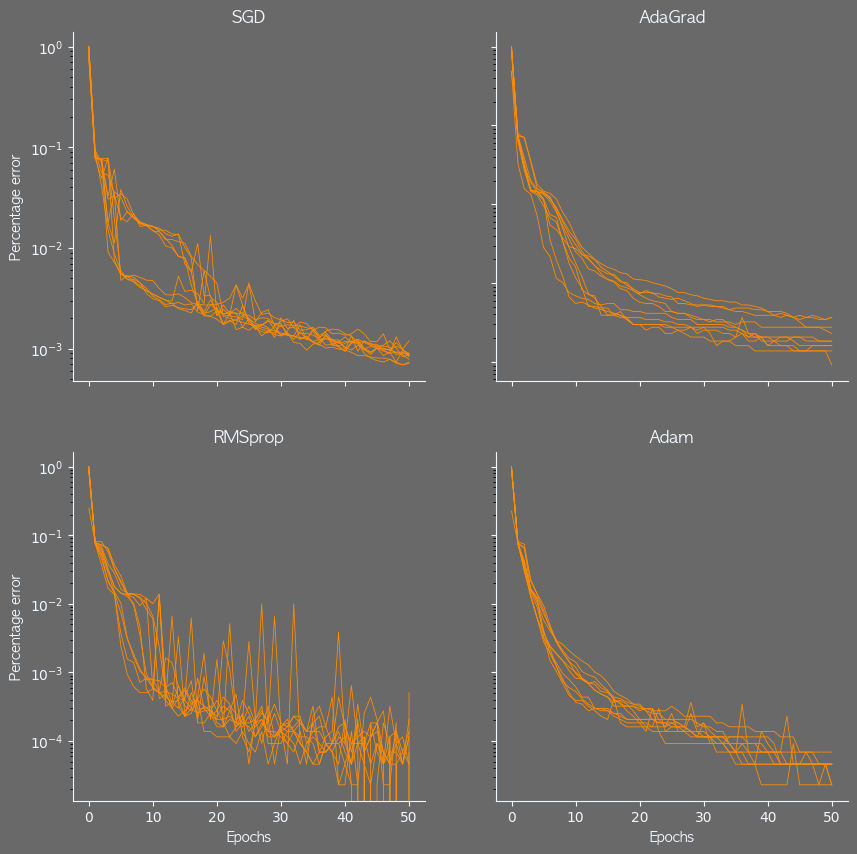

In [33]:
# Load all csv files
SGD_plot = np.loadtxt('SGD.csv', delimiter=',')
SGD_plot = SGD_plot.reshape((10,51))

AdaGrad_plot = np.loadtxt('Adagrad.csv', delimiter=',')
AdaGrad_plot = AdaGrad_plot.reshape((10,51))

RMSprop_plot = np.loadtxt('RMSprop.csv', delimiter=',')
RMSprop_plot = RMSprop_plot.reshape((10,51))

Adam_plot = np.loadtxt('Adam.csv', delimiter=',')
Adam_plot = Adam_plot.reshape((10,51))

# Create plot
fig, axs = plt.subplots(2, 2,figsize=(10, 10))

epochs = np.array(range(0,51))
num_models = 10

for i in range(num_models):
    axs[0, 0].plot(epochs,1-SGD_plot[i],color='darkorange',linewidth=0.6)
    axs[0, 1].plot(epochs,1-AdaGrad_plot[i],color='darkorange',linewidth=0.6)
    axs[1, 0].plot(epochs,1-RMSprop_plot[i],color='darkorange',linewidth=0.6)
    axs[1, 1].plot(epochs,1-Adam_plot[i],color='darkorange',linewidth=0.6)

axs[0, 0].set_title('SGD',**font,color='aliceblue')
axs[0, 1].set_title('AdaGrad',**font,color='aliceblue')
axs[1, 0].set_title('RMSprop',**font,color='aliceblue')
axs[1, 1].set_title('Adam',**font,color='aliceblue')

fig.set_facecolor('dimgray')

for ax in axs.flat:
    
    ax.set_facecolor('dimgray')
    ax.set_yscale('log')
    ax.set_ylabel("Percentage error",**font,color='aliceblue')
    ax.set_xlabel('Epochs',**font,color='aliceblue')

    ax.tick_params(axis='y', colors='aliceblue')
    ax.tick_params(axis='x', colors='aliceblue')
    ax.spines['bottom'].set_color('aliceblue')
    ax.spines['left'].set_color('aliceblue')
    ax.spines['top'].set_color('dimgray')
    ax.spines['right'].set_color('dimgray')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# $ \underline{\text{Testing Model on Unseen data}} $
$ \text{Takes Model object as input and calculates the loss and accuracy of the model}$

In [34]:
def test_model(model,method):
    # Forward pass
    model.input_layer.forward(batch_tst)
    model.activation1.forward(model.input_layer.output)
    model.layer2.forward(model.activation1.output)
    # Calculate loss
    loss = model.loss_activation.forward(model.layer2.output,classfy_tst)
    predictions = np.argmax(model.loss_activation.output,axis=1)
    accuracy = np.mean(predictions==classfy_tst)
    print(f'validation of {method} => acc:{accuracy:.3f},loss:{loss:.3f}')


In [35]:
test_model(SGD_trained,'SGD')
test_model(Ada_trained,'AdaGrad')
test_model(RMSprop_trained,'RMSprop')
test_model(Adam_trained,'Adam')

validation of SGD => acc:0.998,loss:0.010
validation of AdaGrad => acc:0.999,loss:0.006
validation of RMSprop => acc:0.998,loss:0.022
validation of Adam => acc:0.999,loss:0.005
